#Quantum Assisted Gaussian Process Simulations

This work book endeavours to simular Quantum Assisted Gaussian Processes (http://arxiv.org/abs/1512.03929). The code simulates the variance induced by the quantum system when using naturally sparse kernels.


In [1]:
import sys
import os
import numpy as np
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Kernels

We will use three kernels which lead to sparse covariance matrices. The first is from [MacKay](http://www.inference.eng.cam.ac.uk/mackay/gp.pdf):

$k(x,x')= 1 - |x-'x|/d,$ if $|x-'x|<d$

$k(x,x')= 0,$ otherwise

The second is from [Storkey](https://www.researchgate.net/profile/Amos_Storkey/publication/3835514_Truncated_covariance_matrices_and_Toeplitz_methods_in_Gaussian_processes/links/02bfe5120657a2b20f000000.pdf):

$k(x,x')= 1 + cos(|x-'x|/d),$ if $|x-'x|/d<\pi$

$k(x,x')= 0,$ otherwise

Finally, the third is from [Melkumyan](https://www.aaai.org/ocs/index.php/IJCAI/IJCAI-09/paper/viewFile/630/840):

$k(x,x')= \frac{1 - cos(2\pi \frac{|x-'x|}{d})}{3}(1 - \frac{|x-'x|}{d}) + \frac{1}{2\pi}sin(2\pi \frac{|x-'x|}{d}),$ if $|x-'x|<d$

$k(x,x')= 0,$ otherwise

The latter two kernels have very similar properties to the gaussian kernel (also known as the square exponential or rbf kernel).

Each of these kernels may be multiplied by a constant $\sigma^2$ which can be optimised during training. We also note that adding i.i.d. noise does not effect the sparsity. This noise $\sigma_n^2$ will also be optimised.

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:59: RuntimeWarning: covariance is not positive-semidefinite.
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:61: RuntimeWarning: covariance is not positive-semidefinite.


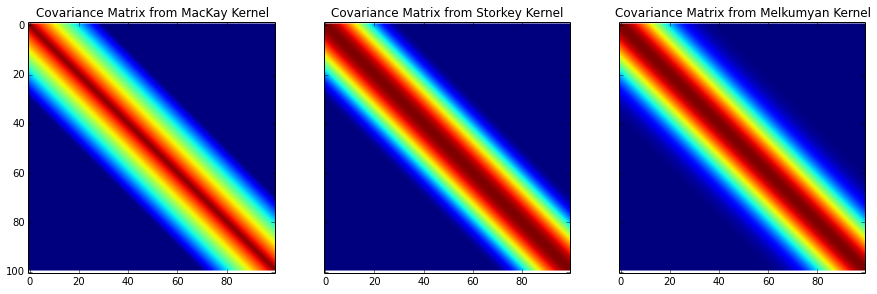

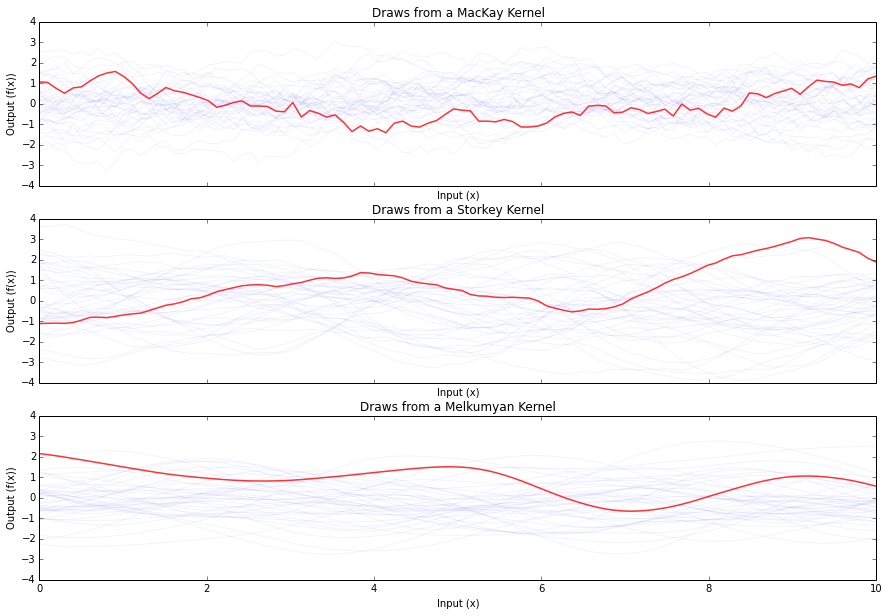

In [11]:
# Define the kernel functions

def kernel_mackay(x, d):
    if np.abs(x) < d:
        return 1 - np.abs((x)/d)
    else:
        return 0
    
def kernel_storkey(x, d):
    if np.abs(x) < d*np.pi:
        return 1 + np.cos((x)/d)
    else:
        return 0 
    
def kernel_melkumyan(x, d):
    if np.abs(x) < d:
        return ((2 + np.cos(2*np.pi*np.abs(x)/d))*(1 - np.abs(x)/d)/3) + np.sin(2*np.pi*np.abs(x)/d)/(2*np.pi)
    else:
        return 0 
    
# Plot the kernels so we can see what we are working with

X = np.linspace(0, 10, 100).reshape(100,)

X_ = np.subtract.outer(X,X)

K_mackay = np.vectorize(kernel_mackay)
K_storkey = np.vectorize(kernel_storkey)
K_melkumyan = np.vectorize(kernel_melkumyan)

K1 = K_mackay(X_, 3.)
K2 = K_storkey(X_, 1.)
K3 = K_melkumyan(X_, 5.)

f, (axa, axb, axc) = plt.subplots(1,3, sharex=True, sharey=True, figsize=[15,4.5])

axa.imshow(K1)
axa.set_title('Covariance Matrix from MacKay Kernel')

axb.imshow(K2)
axb.set_title('Covariance Matrix from Storkey Kernel')

axc.imshow(K3)
axc.set_title('Covariance Matrix from Melkumyan Kernel')

# Plot some draws from their function spaces

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=[15,10])

for r in range(40):
    f = np.random.multivariate_normal(np.zeros(100), K1)
    ax1.plot(X, f, 'b', linewidth=1, label='$f(t)$' if r==0 else None, alpha=0.05)
f = np.random.multivariate_normal(np.zeros(100), K1)
ax1.plot(X, f, 'r', linewidth=1.5, alpha=0.8)
ax1.set_title('Draws from a MacKay Kernel')
ax1.set_xlabel('Input (x)')
ax1.set_ylabel('Output (f(x))')
for r in range(40):
    f = np.random.multivariate_normal(np.zeros(100), K2)
    ax2.plot(X, f, 'b', linewidth=1, label='$f(t)$' if r==0 else None, alpha=0.05)
f = np.random.multivariate_normal(np.zeros(100), K2)
ax2.plot(X, f, 'r', linewidth=1.5, alpha=0.8)
ax2.set_title('Draws from a Storkey Kernel')
ax2.set_xlabel('Input (x)')
ax2.set_ylabel('Output (f(x))')
for r in range(40):
    f = np.random.multivariate_normal(np.zeros(100), K3)
    ax3.plot(X, f, 'b', linewidth=1, label='$f(t)$' if r==0 else None, alpha=0.05)
f = np.random.multivariate_normal(np.zeros(100), K3)
ax3.plot(X, f, 'r', linewidth=1.5, alpha=0.8)
ax3.set_title('Draws from a Melkumyan Kernel')
ax3.set_xlabel('Input (x)')
ax3.set_ylabel('Output (f(x))')

## Datasets

We will check out three datasets where we might expect GPs using the above functions to model the data reasonably well.

### Property Dataset
### Airplane Dataset
### Land Altitude Dataset